### 1. Objective <a name = "Objective"></a>
- Build a model to forecast the demand of Store items.
- The data is classified in date/time, store, item and the sales per day

### 2. Data Loading and Visualization <a name = "Data Loading and Visualization"></a>

__Import the dataset__ 

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
storeds  =  pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Store_Item_demand_forecast.csv')
storeds.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
print("number of unique items :",storeds.item.nunique())
print("number of unique store :",storeds.store.nunique())

number of unique items : 50
number of unique store : 10


In [ ]:
storeds['date'] = pd.to_datetime(storeds['date'],infer_datetime_format=True)
storeds['dayofmonth'] = storeds.date.dt.day
storeds['dayofyear'] = storeds.date.dt.dayofyear
storeds['dayofweek'] = storeds.date.dt.dayofweek
storeds['month'] = storeds.date.dt.month
storeds['year'] = storeds.date.dt.year
storeds['weekofyear'] = storeds.date.dt.weekofyear
storeds.head()
storeds.drop(['date'], axis = 1) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,store,item,sales,dayofmonth,dayofyear,dayofweek,month,year,weekofyear
0,1,1,13,1,1,1,1,2013,1
1,1,1,11,2,2,2,1,2013,1
2,1,1,14,3,3,3,1,2013,1
3,1,1,13,4,4,4,1,2013,1
4,1,1,10,5,5,5,1,2013,1
...,...,...,...,...,...,...,...,...,...
912995,10,50,63,27,361,2,12,2017,52
912996,10,50,59,28,362,3,12,2017,52
912997,10,50,74,29,363,4,12,2017,52
912998,10,50,62,30,364,5,12,2017,52


#### Visualization

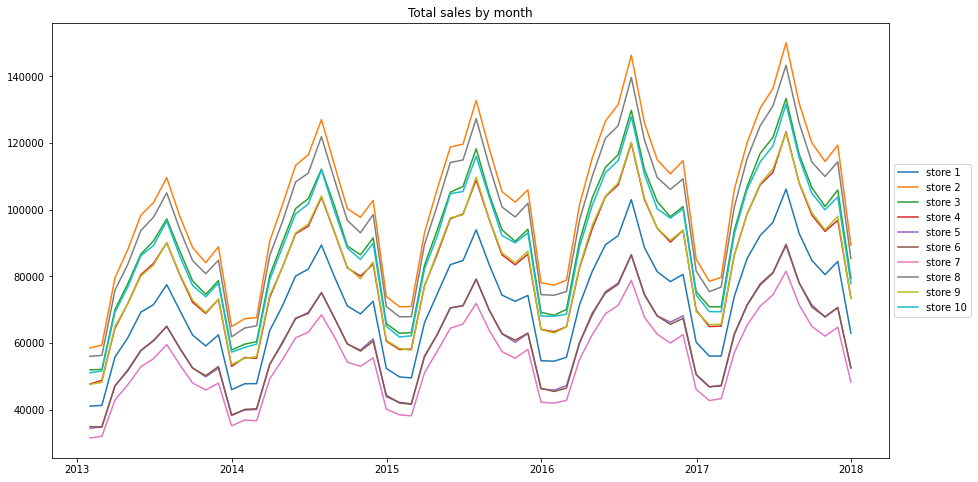

In [ ]:
plt.figure(figsize=(15,8))
for i in range(1,11):
    month_df = storeds[storeds.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index)
    y=np.array(month_df.sales)
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total sales by month")
plt.show()

#### Sales by Date:

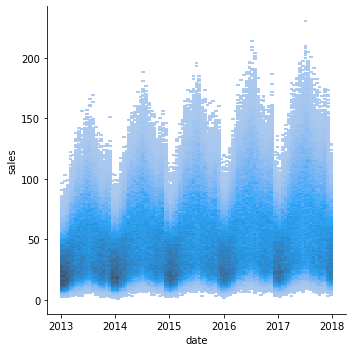

In [ ]:
sns.displot(storeds, x="date", y="sales")

#### Monthly Sales:

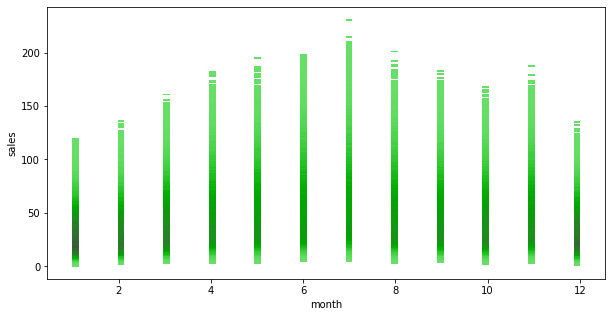

In [ ]:
sns.histplot(storeds, x="month", y="sales", color="g")

#### Weekely Sales:

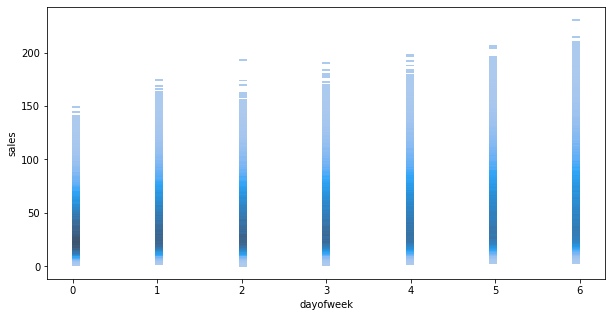

In [ ]:
# sns.boxplot(x="dayofweek", y="sales",data="storeds")
sns.histplot(storeds, x="dayofweek", y="sales")

### 3. Decomposition

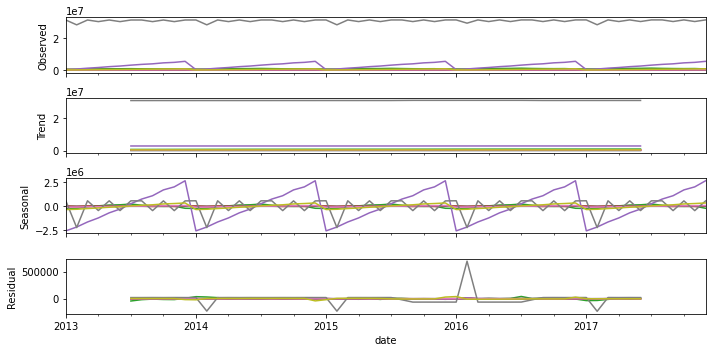

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']  =  10, 5

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_storeds  =  seasonal_decompose(storeds.resample('M',on='date').sum())         
figure  =  decomposed_storeds.plot()
plt.show()

### 4. Restructuring data

In [ ]:
store_list = []
items_by_store = []
daily_sales_list = []
weekly_sales_list = []
monthly_sales_list = []


for i in range(1, 11):
    store = storeds[storeds.store == i]
    store_list.append(store)
    
    
for i in store_list:
    sales_items = i.drop(columns='sales')
    items_by_store.append(sales_items)

for i in store_list:
    daily_sales = i.reset_index().resample('D', on='date').sum()
    daily_sales = pd.DataFrame(daily_sales.sales)
    daily_sales_list.append(daily_sales)
  
    
for i in store_list:
    weekly_sales = i.reset_index().resample('W', on='date').sum()
    weekly_sales = pd.DataFrame(weekly_sales.sales)
    weekly_sales_list.append(weekly_sales)
    
for i in store_list:
    monthly_sales = i.reset_index().resample('M', on='date').sum()
    monthly_sales = pd.DataFrame(monthly_sales.sales)
    monthly_sales_list.append(monthly_sales)


In [ ]:
store1_weekly_sales = weekly_sales_list[0]
print(len(store1_weekly_sales))
store1_weekly_sales.tail()

261


,sales
date,
2017-12-03,16922
2017-12-10,13949
2017-12-17,14149
2017-12-24,14114
2017-12-31,14015


### 5. Stationarity Check <a name = "Stationarity Check"></a>


In [ ]:
def test_stationarity(time_series):
    rolling_means(time_series)
    dickey_fuller_test(time_series)

#### 5.1 Rolling Statistics Methodology

In [ ]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    #Plot rolling statistics

    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)


#### Rolling stats for weekely sales:

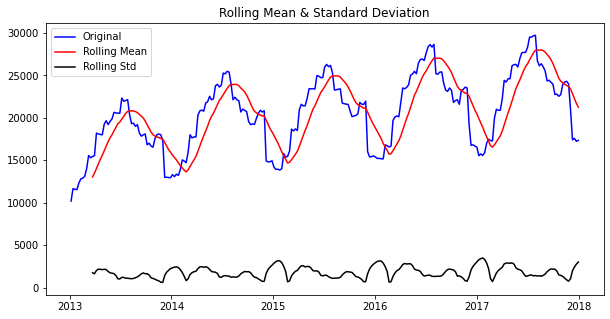

In [ ]:
rolling_means(weekly_sales.sales)

#### For monthly sales

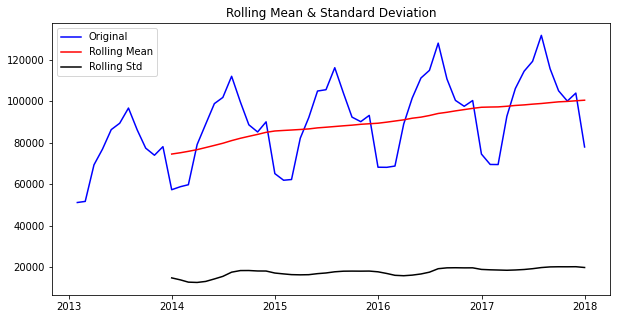

In [ ]:
rolling_means(monthly_sales.sales)

#### 5.2 ADF(Augmented Dickey-Fuller) Test 

In [ ]:
import statsmodels.tsa.stattools as ts
def dickey_fuller_test(timeseries):
    dickey_fuller_test = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

#### Test on weekely sales

Test Statistic           -3.321226
p-value                   0.013956
Lags Used                 4.000000
Observations Used       256.000000
Critical Value (1%)      -3.456155
Critical Value (5%)      -2.872897
Critical Value (10%)     -2.572822
dtype: float64


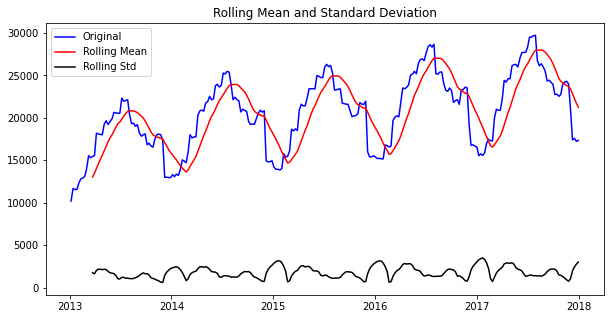

In [ ]:

dickey_fuller_test(weekly_sales.sales)

#### Test on monthly data

Test Statistic          -5.144744
p-value                  0.000011
Lags Used               11.000000
Observations Used       48.000000
Critical Value (1%)     -3.574589
Critical Value (5%)     -2.923954
Critical Value (10%)    -2.600039
dtype: float64


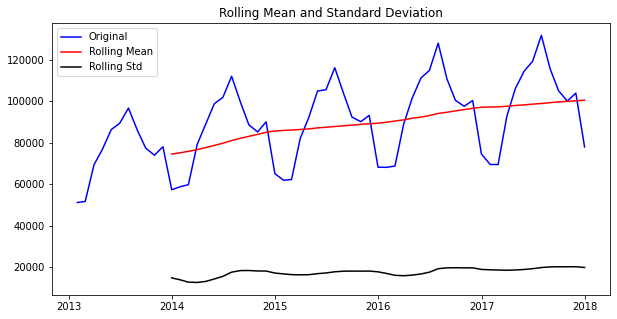

In [ ]:
dickey_fuller_test(monthly_sales.sales)

### 7. Train Test Split


In [ ]:
W = weekly_sales_list
weekly_sales_train_list = []
weekly_sales_test_list = []

for i in W:
    train_size = int(len(weekly_sales_list) * 0.80)
    weekly_sales_train, weekly_sales_test = i[0:train_size], i[train_size:]
    weekly_sales_train = pd.DataFrame(weekly_sales_train.sales)
    weekly_sales_train_list.append(weekly_sales_train)
    weekly_sales_test = pd.DataFrame(weekly_sales_test.sales)
    weekly_sales_test_list.append(weekly_sales_test)

In [ ]:
print(len(weekly_sales_list[0]))
print(len(weekly_sales_train_list[0]))
print(len(weekly_sales_test_list[0]))

261
208
53


In [ ]:

M = monthly_sales_list
monthly_sales_train_list = []
monthly_sales_test_list = []

for i in M:
    train_size = int(len(monthly_sales_list) * 0.80)
    monthly_sales_train, monthly_sales_test = i[0:train_size], i[train_size:]
    monthly_sales_train = pd.DataFrame(monthly_sales_train.sales)
    monthly_sales_train_list.append(monthly_sales_train)
    monthly_sales_test = pd.DataFrame(monthly_sales_test.sales)
    monthly_sales_test_list.append(monthly_sales_test)

In [ ]:
print(len(monthly_sales_list[0]))
print(len(monthly_sales_train_list[0]))
print(len(monthly_sales_test_list[0]))

60
48
12


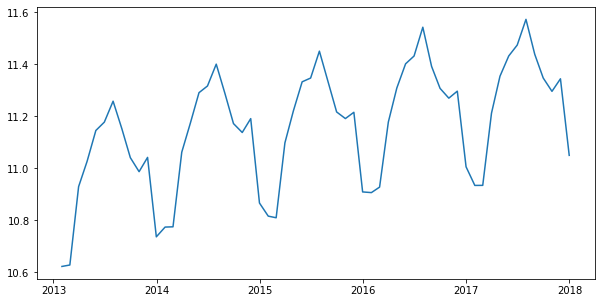

In [ ]:
import numpy as np
monthly_sales_list_s1_logScale  =  np.log(monthly_sales_list[0])
rcParams['figure.figsize']  =  10, 5
plt.plot(monthly_sales_list_s1_logScale)

### 8. Building Models

#### 8.1 AR Model

In [ ]:
from statsmodels.tsa.ar_model import AR
model = AR(monthly_sales_train_list[0])
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 6
Coefficients: const       0.000014
L1.sales    0.382726
L2.sales    0.738486
L3.sales    0.060429
L4.sales    0.193317
L5.sales   -0.925632
L6.sales    0.553058
dtype: float64


In [ ]:
predictions = model_fit.predict(start=len(monthly_sales_train_list[0]), end=len(monthly_sales_train_list[0])+len(monthly_sales_test_list[0])-1, dynamic=False)
predictions.head()
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], monthly_sales_test_list[0].iloc[i]))


predicted=75587.669748, expected=62408.000000
predicted=68853.438792, expected=59130.000000
predicted=73474.323243, expected=62465.000000
predicted=64817.661642, expected=46029.000000
predicted=76158.946813, expected=47788.000000
predicted=63372.054647, expected=47838.000000
predicted=76688.506916, expected=63729.000000
predicted=63352.312109, expected=71149.000000
predicted=80070.491032, expected=80108.000000
predicted=59667.650835, expected=82196.000000
predicted=84081.858782, expected=89389.000000
predicted=57392.701914, expected=79794.000000
predicted=86915.803284, expected=71134.000000
predicted=53186.010214, expected=68740.000000
predicted=93317.690746, expected=72506.000000
predicted=46510.175216, expected=52415.000000
predicted=100108.312993, expected=49842.000000
predicted=39871.373179, expected=49530.000000
predicted=108877.618825, expected=66056.000000
predicted=29192.407400, expected=74701.000000
predicted=121898.066952, expected=83523.000000
predicted=15558.180168, expecte

- __Model evaluation__ using Mean_squared_error

Test MSE: 1050671391669.335


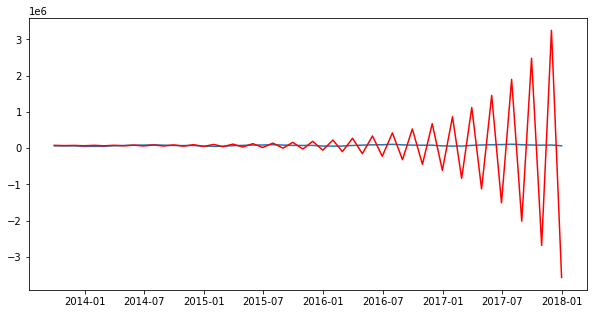

In [ ]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(monthly_sales_test_list[0], predictions)
print('Test MSE: %.3f' % error)
# plot results

pyplot.plot(monthly_sales_test_list[0])
pyplot.plot(predictions, color='red')
pyplot.show()

Plotting AR model


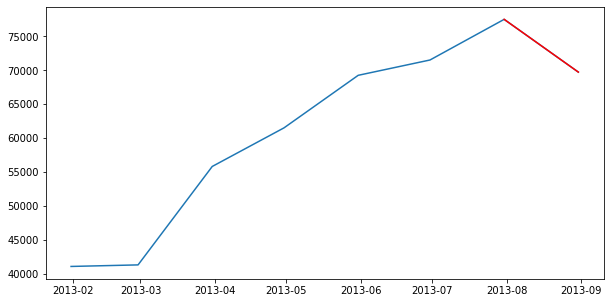

In [ ]:
plt.plot(monthly_sales_train_list[0])
plt.plot(model_fit.fittedvalues, color = 'red')
print('Plotting AR model')

This model didn't return the expected result

#### 8.2 ARIMA Model 

Store No.: 1
Test RMSE: 8736.203
Store No.: 2
Test RMSE: 12407.833
Store No.: 3
Test RMSE: 10942.083
Store No.: 4
Test RMSE: 10066.084
Store No.: 5
Test RMSE: 7373.806
Store No.: 6
Test RMSE: 7356.437
Store No.: 7
Test RMSE: 6745.320
Store No.: 8
Test RMSE: 11834.134
Store No.: 9
Test RMSE: 10186.577
Store No.: 10
Test RMSE: 10882.099


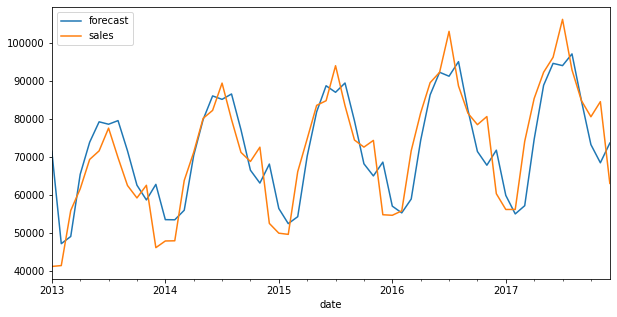

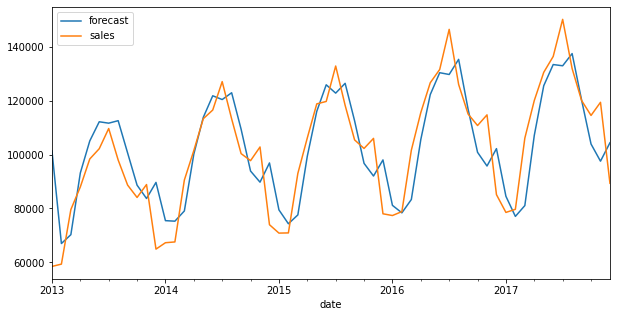

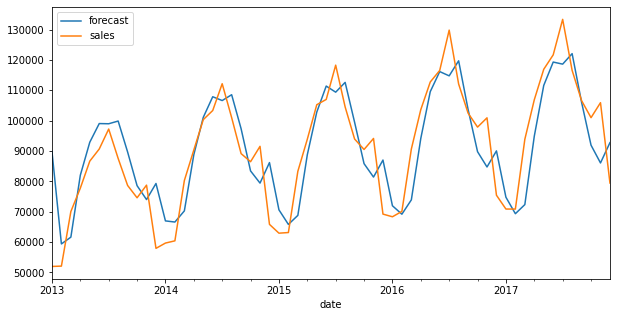

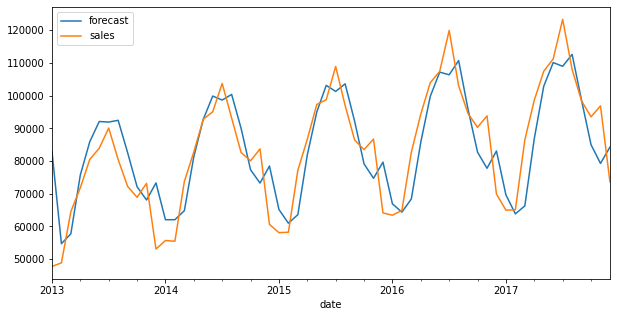

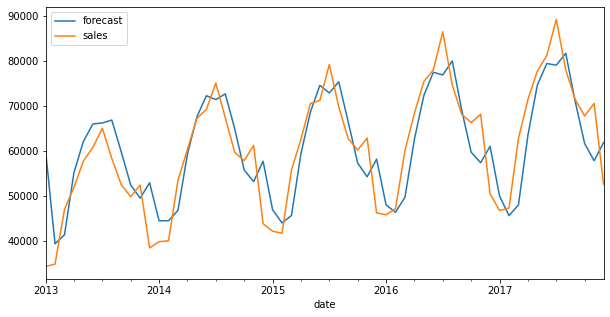

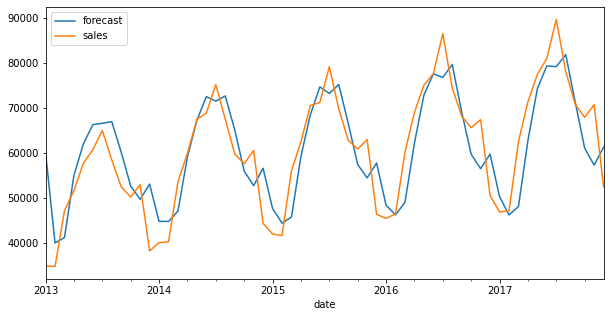

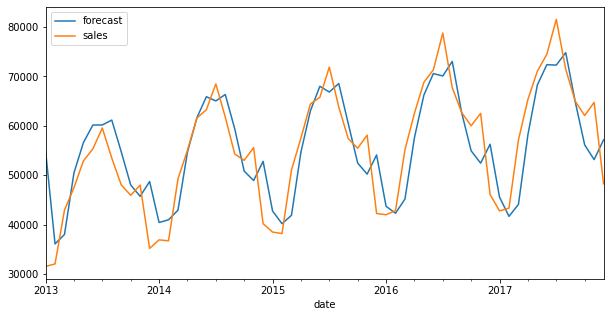

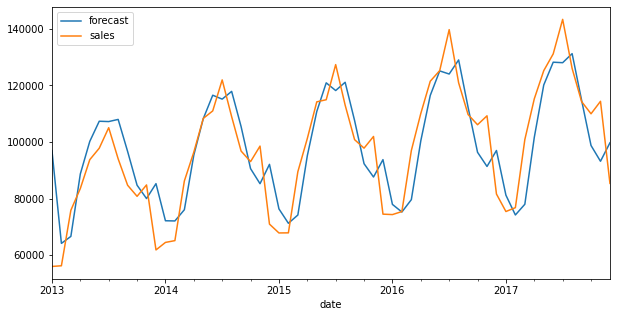

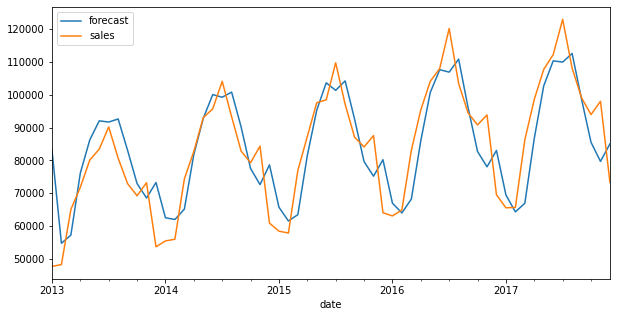

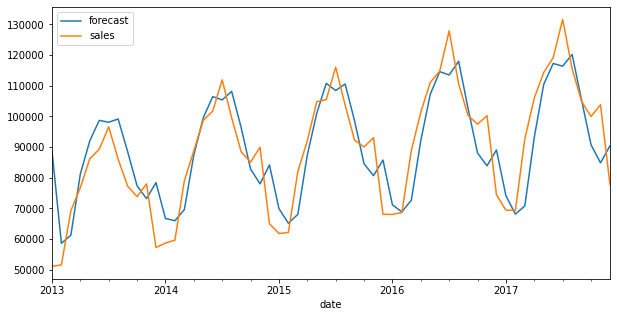

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
model = []
for i in range(len(monthly_sales_list)):
  model.append(ARIMA(monthly_sales_list[i],order=(2,0,2)))
  results_ARIMA = model[i].fit()
  j = i+1
  print('Store No.: %s' % j)
  error = sqrt(mean_squared_error(monthly_sales_list[i], results_ARIMA.fittedvalues))
  print('Test RMSE: %.3f' % error)
  fitted_values = results_ARIMA.plot_predict()

### 9. Sales Forecast

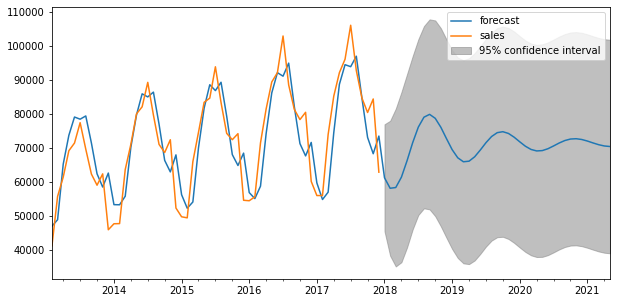

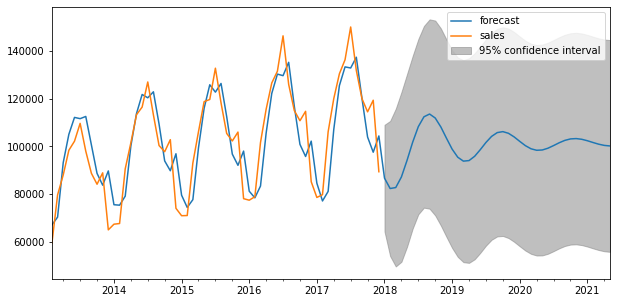

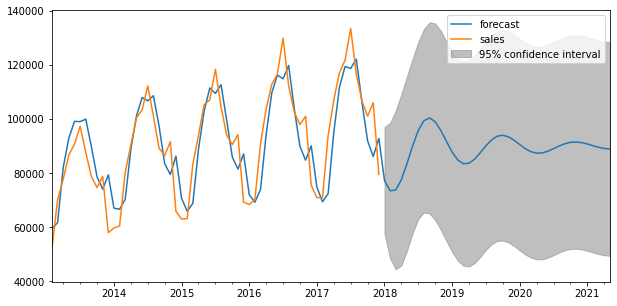

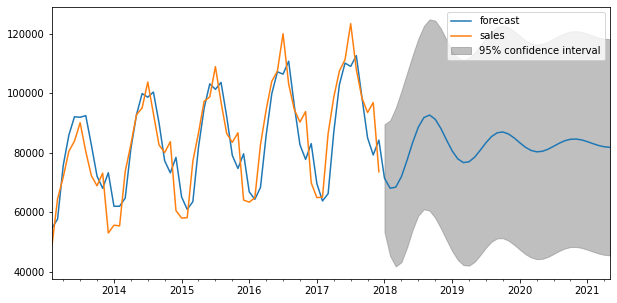

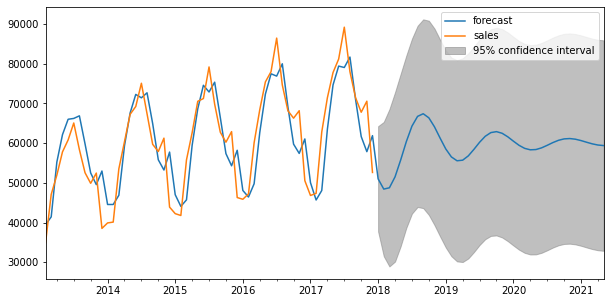

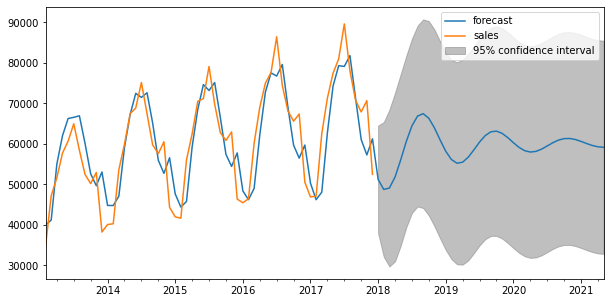

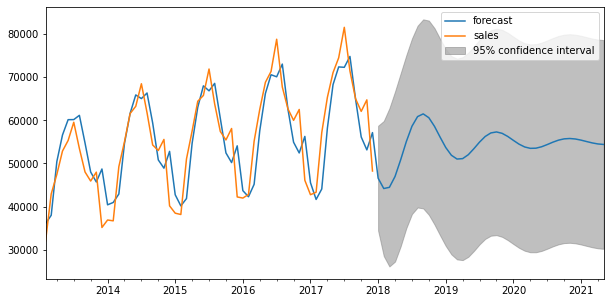

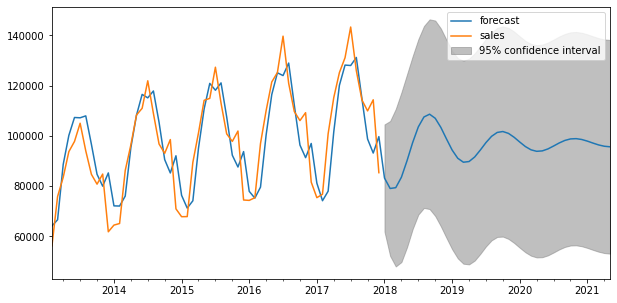

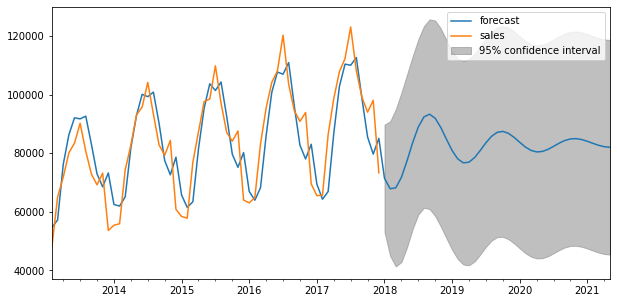

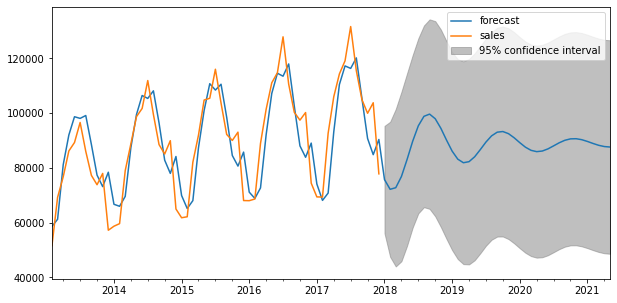

In [ ]:
model = []
for i in range(len(monthly_sales_list)):
  model.append(ARIMA(monthly_sales_list[i],order=(2,0,2)))
  results_ARIMA = model[i].fit()
  predicted_result = results_ARIMA.plot_predict(1,100) 

### Conclusion:



* EDA shows that data has seasonal component   
* ARIMA worked best for future prediction





